## TensorFlow 2.0 선택
[런타임] -> [런타임 유형변경]에서 하드웨어 가속기를 꼭 GPU로 설정!

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


## Coding Tips
Neural Network coding 시에 아래와 같이 구분하여 만들자
#### 1. Hyper Paramter 정하기
#### 2. Data 준비(불러오기 or download 등)
#### 3. Dataset 구성 (tf.data.Dataset 이용)
#### 4. Modlel 만들기 (Neural Network model)
#### 5. Loss function 정의, Optimizer 선택
#### 6. Training (Train, Test function 만들기 포함)
#### 7. Validation(or Test) 결과 확인

## Importing Libraries

In [2]:
## Library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.1.0-rc1
2.2.4-tf


## Hyper Parameters

In [0]:
learning_rate = 0.001
training_epochs = 20
batch_size = 100
n_class = 10

## MNIST/Fashion MNIST Data

In [0]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [5]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()  

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
## train_images, train_labels의 type 확인
type(train_images), type(train_labels)

(numpy.ndarray, numpy.ndarray)

In [7]:
## train_images, train_labels의 shape 확인
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [8]:
## test_images, test_labels의 shape 확인
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

In [9]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(train_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 5923,
 1: 6742,
 2: 5958,
 3: 6131,
 4: 5842,
 5: 5421,
 6: 5918,
 7: 6265,
 8: 5851,
 9: 5949}

In [10]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(test_labels, axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 980,
 1: 1135,
 2: 1032,
 3: 1010,
 4: 982,
 5: 892,
 6: 958,
 7: 1028,
 8: 974,
 9: 1009}

In [0]:
## train dataset, test dataset의 개수 저장
n_train = train_images.shape[0]
n_test = test_images.shape[0]

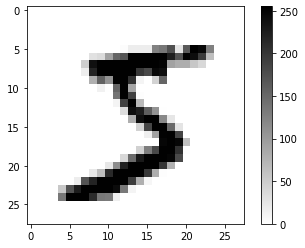

In [12]:
## train_images의 0번 image 화면에 출력
plt.figure()
plt.imshow(train_images[0], cmap=plt.cm.binary)
plt.colorbar()
plt.show()

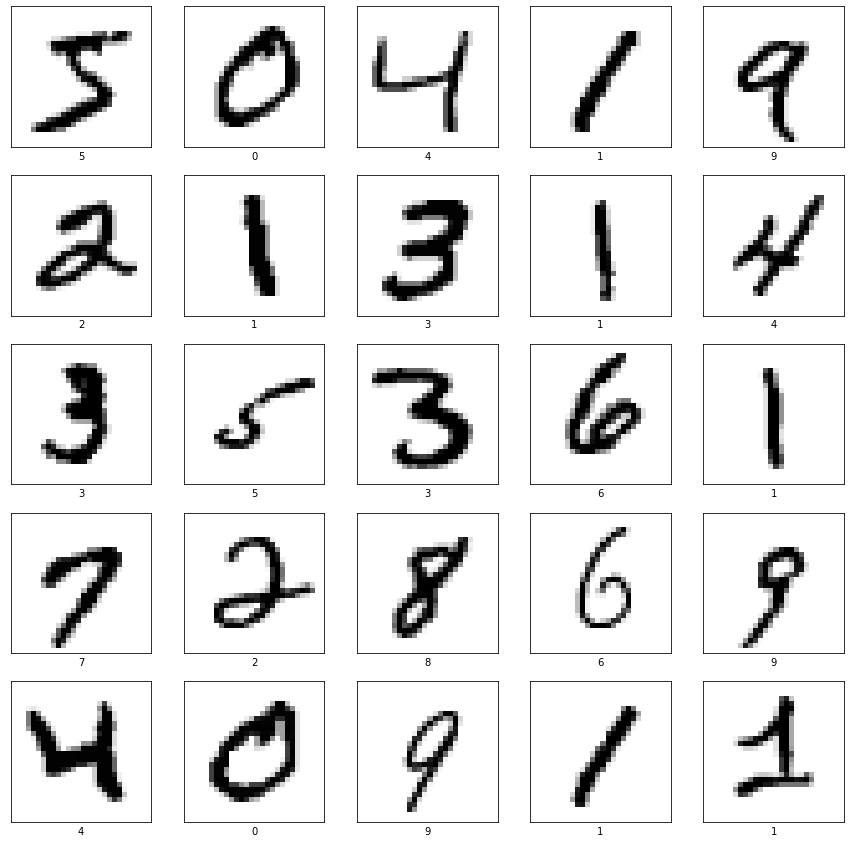

In [13]:
## 25개의 train image와 label 화면에 출력
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

In [0]:
## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Linear Regression Model

In [0]:
def create_lr_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [17]:
lr_model = create_lr_model()
lr_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


## Loss & Optimizer

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [0]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.CategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.CategoricalAccuracy()

## Train & Test function

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = lr_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, lr_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, lr_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  predictions = lr_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

## Training

In [22]:
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.6199, accuracy: 0.8463, val_loss: 0.3610, val_accuracy: 0.9055
Epoch: 2, loss: 0.4826, accuracy: 0.8759, val_loss: 0.3346, val_accuracy: 0.9106
Epoch: 3, loss: 0.4248, accuracy: 0.8887, val_loss: 0.3193, val_accuracy: 0.9138
Epoch: 4, loss: 0.3917, accuracy: 0.8961, val_loss: 0.3098, val_accuracy: 0.9157
Epoch: 5, loss: 0.3698, accuracy: 0.9011, val_loss: 0.3026, val_accuracy: 0.9176
Epoch: 6, loss: 0.3540, accuracy: 0.9048, val_loss: 0.2974, val_accuracy: 0.9186
Epoch: 7, loss: 0.3420, accuracy: 0.9075, val_loss: 0.2938, val_accuracy: 0.9195
Epoch: 8, loss: 0.3324, accuracy: 0.9098, val_loss: 0.2904, val_accuracy: 0.9202
Epoch: 9, loss: 0.3246, accuracy: 0.9118, val_loss: 0.2876, val_accuracy: 0.9210
Epoch: 10, loss: 0.3180, accuracy: 0.9134, val_loss: 0.2853, val_accuracy: 0.9217
Epoch: 11, loss: 0.3125, accuracy: 0.9148, val_loss: 0.2836, val_accuracy: 0.9220
Epoch: 12, loss: 0.3077, accuracy: 0.9160, val_loss: 0.2818, val_accuracy: 0.9225
Epoch: 13, loss: 0.3035, 

# Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
lr_model_k = create_lr_model()

## Model Compile(Optimizer & Loss Function)

In [0]:
lr_model_k.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

## Training

In [27]:
steps_per_epoch = n_train//batch_size
validation_steps = n_test//batch_size
print(steps_per_epoch, validation_steps) 

600 100


In [28]:
history = lr_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 4ms/step - loss: 0.6352 - accuracy: 0.8399 - val_loss: 0.3654 - val_accuracy: 0.9026
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 0.3476 - accuracy: 0.9048 - val_loss: 0.3102 - val_accuracy: 0.9133
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.3106 - accuracy: 0.9139 - val_loss: 0.2901 - val_accuracy: 0.9190
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2929 - accuracy: 0.9186 - val_loss: 0.2802 - val_accuracy: 0.9213
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2827 - accuracy: 0.9211 - val_loss: 0.2772 - val_accuracy: 0.9227
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2751 - accuracy: 0.9232 - val_loss: 0.2716 - val_accuracy: 0.9240
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2698 - accuracy: 0.9248 - va

## Training 결과 확인

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(n_class), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(n_class), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

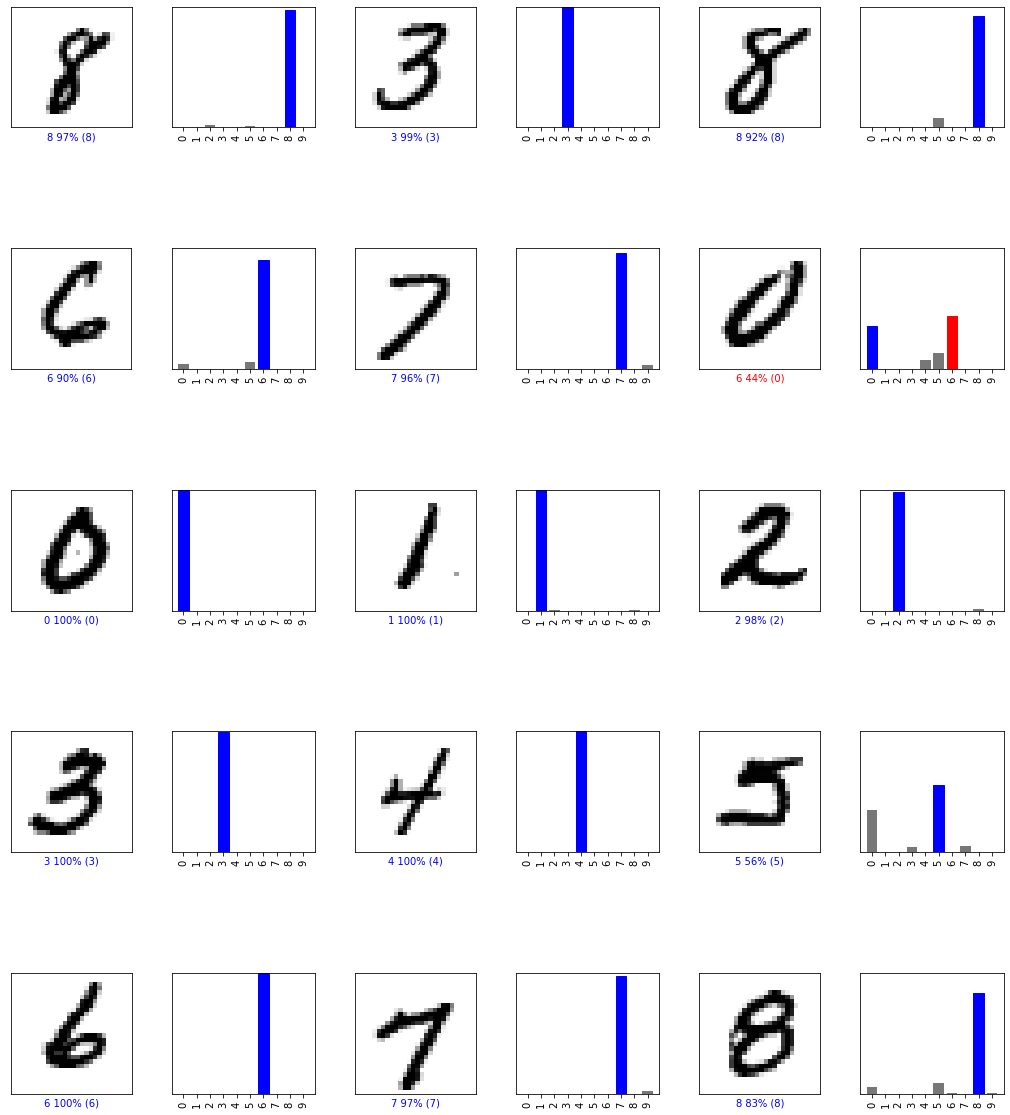

In [30]:
rnd_idx = np.random.randint(1, n_test//batch_size)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = lr_model_k(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

## Multi-Layer Perceptron Model - 3 layers

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성 - repeat() 다시 빼기 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [0]:
def create_mlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [34]:
mlp_model = create_mlp_model()
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


In [0]:
## reset metrics
train_loss.reset_states()
train_accuracy.reset_states()
test_loss.reset_states()
test_accuracy.reset_states()

In [0]:
## train function
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = mlp_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, mlp_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, mlp_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
## test function
@tf.function
def test_step(images, labels):
  predictions = mlp_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [38]:
## Training
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.1860, accuracy: 0.9438, val_loss: 0.1014, val_accuracy: 0.9680
Epoch: 2, loss: 0.1289, accuracy: 0.9609, val_loss: 0.0897, val_accuracy: 0.9712
Epoch: 3, loss: 0.1013, accuracy: 0.9692, val_loss: 0.0816, val_accuracy: 0.9736
Epoch: 4, loss: 0.0839, accuracy: 0.9744, val_loss: 0.0777, val_accuracy: 0.9750
Epoch: 5, loss: 0.0716, accuracy: 0.9780, val_loss: 0.0758, val_accuracy: 0.9759
Epoch: 6, loss: 0.0623, accuracy: 0.9809, val_loss: 0.0745, val_accuracy: 0.9768
Epoch: 7, loss: 0.0553, accuracy: 0.9831, val_loss: 0.0753, val_accuracy: 0.9769
Epoch: 8, loss: 0.0500, accuracy: 0.9846, val_loss: 0.0753, val_accuracy: 0.9773
Epoch: 9, loss: 0.0456, accuracy: 0.9859, val_loss: 0.0763, val_accuracy: 0.9774
Epoch: 10, loss: 0.0421, accuracy: 0.9870, val_loss: 0.0763, val_accuracy: 0.9777
Epoch: 11, loss: 0.0389, accuracy: 0.9880, val_loss: 0.0776, val_accuracy: 0.9779
Epoch: 12, loss: 0.0364, accuracy: 0.9887, val_loss: 0.0778, val_accuracy: 0.9781
Epoch: 13, loss: 0.0341, 

## Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
mlp_model_k = create_mlp_model()

In [0]:
## model compile
mlp_model_k.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [42]:
## training
history = mlp_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 4ms/step - loss: 0.2540 - accuracy: 0.9262 - val_loss: 0.1160 - val_accuracy: 0.9660
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0967 - accuracy: 0.9708 - val_loss: 0.0882 - val_accuracy: 0.9727
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0627 - accuracy: 0.9807 - val_loss: 0.0809 - val_accuracy: 0.9753
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0450 - accuracy: 0.9860 - val_loss: 0.0704 - val_accuracy: 0.9787
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0653 - val_accuracy: 0.9807
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0254 - accuracy: 0.9918 - val_loss: 0.0779 - val_accuracy: 0.9773
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0203 - accuracy: 0.9934 - va

## Multi-Layer Perceptron Model - 5 layers

In [0]:
## MNIST dataset load
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## image를 0~1사이 값으로 만들기 위하여 255로 나누어줌
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

## one-hot encoding
train_labels = to_categorical(train_labels, n_class)
test_labels = to_categorical(test_labels, n_class)

In [0]:
## dataset 구성 - repeat() 다시 빼기 
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

In [0]:
def create_dmlp_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dense(256, activation='relu'))    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(128, activation='relu'))    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [46]:
dmlp_model = create_dmlp_model()
dmlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
## reset metrics
train_loss.reset_states()
train_accuracy.reset_states()
test_loss.reset_states()
test_accuracy.reset_states()

In [0]:
## train function
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = dmlp_model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, dmlp_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, dmlp_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
## test function
@tf.function
def test_step(images, labels):
  predictions = dmlp_model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [50]:
## Training
for epoch in range(training_epochs):
  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  template = 'Epoch: {}, loss: {:.4f}, accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result(),
                         test_loss.result(),
                         test_accuracy.result()))

Epoch: 1, loss: 0.2062, accuracy: 0.9363, val_loss: 0.1003, val_accuracy: 0.9687
Epoch: 2, loss: 0.1437, accuracy: 0.9558, val_loss: 0.0886, val_accuracy: 0.9724
Epoch: 3, loss: 0.1130, accuracy: 0.9650, val_loss: 0.0892, val_accuracy: 0.9728
Epoch: 4, loss: 0.0946, accuracy: 0.9707, val_loss: 0.0869, val_accuracy: 0.9736
Epoch: 5, loss: 0.0825, accuracy: 0.9744, val_loss: 0.0903, val_accuracy: 0.9736
Epoch: 6, loss: 0.0728, accuracy: 0.9773, val_loss: 0.0884, val_accuracy: 0.9746
Epoch: 7, loss: 0.0654, accuracy: 0.9796, val_loss: 0.0880, val_accuracy: 0.9752
Epoch: 8, loss: 0.0596, accuracy: 0.9814, val_loss: 0.0883, val_accuracy: 0.9756
Epoch: 9, loss: 0.0550, accuracy: 0.9828, val_loss: 0.0883, val_accuracy: 0.9758
Epoch: 10, loss: 0.0510, accuracy: 0.9841, val_loss: 0.0913, val_accuracy: 0.9759
Epoch: 11, loss: 0.0479, accuracy: 0.9851, val_loss: 0.0913, val_accuracy: 0.9764
Epoch: 12, loss: 0.0450, accuracy: 0.9859, val_loss: 0.0902, val_accuracy: 0.9769
Epoch: 13, loss: 0.0425, 

## Using Keras

In [0]:
## dataset에 repeat()추가
train_dataset = train_dataset.repeat()
test_dataset = test_dataset.repeat()

In [0]:
## 새로운 model 만들기
dmlp_model_k = create_dmlp_model()

In [0]:
## model compile
dmlp_model_k.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [54]:
## training
history = dmlp_model_k.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2436 - accuracy: 0.9280 - val_loss: 0.1149 - val_accuracy: 0.9631
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0923 - accuracy: 0.9717 - val_loss: 0.0822 - val_accuracy: 0.9740
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0622 - accuracy: 0.9810 - val_loss: 0.0759 - val_accuracy: 0.9762
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0487 - accuracy: 0.9850 - val_loss: 0.0758 - val_accuracy: 0.9757
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0389 - accuracy: 0.9875 - val_loss: 0.0901 - val_accuracy: 0.9742
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.0676 - val_accuracy: 0.9812
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0311 - accuracy: 0.9900 - va

## Drop-out

In [0]:
drop_rate = 0.3

def create_do_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(drop_rate))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [56]:
do_model = create_do_model()
do_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [0]:
do_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [58]:
history = do_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.4456 - accuracy: 0.8625 - val_loss: 0.1436 - val_accuracy: 0.9580
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1865 - accuracy: 0.9482 - val_loss: 0.1070 - val_accuracy: 0.9691
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1467 - accuracy: 0.9591 - val_loss: 0.0965 - val_accuracy: 0.9716
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1237 - accuracy: 0.9655 - val_loss: 0.0873 - val_accuracy: 0.9747
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1069 - accuracy: 0.9702 - val_loss: 0.0843 - val_accuracy: 0.9747
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0946 - accuracy: 0.9728 - val_loss: 0.0767 - val_accuracy: 0.9778
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0867 - accuracy: 0.9755 - va

## Weight Decay (L2 Regulrarization)

In [0]:
reg_weight = 0.0002

def create_l2r_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(256, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    model.add(keras.layers.Dense(128, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))    
    model.add(keras.layers.Dense(10, activation='softmax',
                                kernel_regularizer=keras.regularizers.l2(reg_weight)))
    return model

In [60]:
l2r_model = create_l2r_model()
l2r_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
l2r_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [63]:
history = l2r_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.3931 - accuracy: 0.9233 - val_loss: 0.2791 - val_accuracy: 0.9531
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.2261 - accuracy: 0.9676 - val_loss: 0.2089 - val_accuracy: 0.9703
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1882 - accuracy: 0.9761 - val_loss: 0.1942 - val_accuracy: 0.9718
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1640 - accuracy: 0.9797 - val_loss: 0.1860 - val_accuracy: 0.9731
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1503 - accuracy: 0.9829 - val_loss: 0.1651 - val_accuracy: 0.9772
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1401 - accuracy: 0.9842 - val_loss: 0.1589 - val_accuracy: 0.9785
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.1306 - accuracy: 0.9849 - va

## Batch Normalization

In [0]:
def create_bn_model():
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(256))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(128))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.ReLU())
    model.add(keras.layers.Dense(10))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Softmax())
    return model

In [65]:
bn_model = create_bn_model()
bn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               200960    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)              

In [0]:
bn_model.compile(optimizer=keras.optimizers.Adam(learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [67]:
history = bn_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 5s 9ms/step - loss: 0.3813 - accuracy: 0.9381 - val_loss: 0.2014 - val_accuracy: 0.9692
Epoch 2/20
600/600 [==============================] - 4s 7ms/step - loss: 0.1624 - accuracy: 0.9719 - val_loss: 0.1230 - val_accuracy: 0.9728
Epoch 3/20
600/600 [==============================] - 4s 7ms/step - loss: 0.1054 - accuracy: 0.9799 - val_loss: 0.1045 - val_accuracy: 0.9742
Epoch 4/20
600/600 [==============================] - 4s 6ms/step - loss: 0.0738 - accuracy: 0.9848 - val_loss: 0.0803 - val_accuracy: 0.9794
Epoch 5/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0596 - accuracy: 0.9863 - val_loss: 0.0930 - val_accuracy: 0.9754
Epoch 6/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0479 - accuracy: 0.9885 - val_loss: 0.0715 - val_accuracy: 0.9801
Epoch 7/20
600/600 [==============================] - 4s 7ms/step - loss: 0.0383 - accuracy: 0.9909 - va

## Learning Rate Decay

In [68]:
lr_decay_model = create_dmlp_model()
lr_decay_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_37 (Dense)             (None, 10)                1290      
Total params: 317,450
Trainable params: 317,450
Non-trainable params: 0
________________________________________________

In [0]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=learning_rate,
                                                          decay_steps=n_train//batch_size*10,
                                                          decay_rate=0.5,
                                                          staircase=True)

In [0]:
lr_decay_model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])

In [71]:
history = lr_decay_model.fit(train_dataset, epochs=training_epochs, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Train for 600 steps, validate for 100 steps
Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.2491 - accuracy: 0.9258 - val_loss: 0.1143 - val_accuracy: 0.9630
Epoch 2/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0931 - accuracy: 0.9710 - val_loss: 0.0986 - val_accuracy: 0.9709
Epoch 3/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0670 - accuracy: 0.9793 - val_loss: 0.0818 - val_accuracy: 0.9763
Epoch 4/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0497 - accuracy: 0.9837 - val_loss: 0.0760 - val_accuracy: 0.9771
Epoch 5/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0385 - accuracy: 0.9877 - val_loss: 0.1184 - val_accuracy: 0.9659
Epoch 6/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.9903 - val_loss: 0.0784 - val_accuracy: 0.9771
Epoch 7/20
600/600 [==============================] - 2s 4ms/step - loss: 0.0282 - accuracy: 0.9908 - va